<a href="https://colab.research.google.com/github/LUcfarmer6/Numerical_Methods_Proj/blob/master/ISV_Proj_checking_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 --------------------------------------------------------------
   # Numerical Methods ISV Model Using Newton-Raphson Method -- TESTING
--------------------------------------------------------------

Description:
This model utilizes a set of material constants ($C_n$ through $C_m$)
along with inputs of strain rate and time step to calculate and predict
an accurate stress-strain curve for that given material. This is a
viscoplastic model (strain-rate sensitive) that uses a Radial-Return
scheme to predict deformation elastically, and then correct for any plastic
deformation that also occurs. Plastic deformation behavior is governed by
the Flow Rule and Isotropic Hardening. These equations may be solved either
analytically or numerically (using the Newton-Raphson (N-R) method). The analytical
method will be solved first, requiring a much smaller time step for
accuracy, while the N-R method is solved second which retains accuracy at
much greater time steps. The two methods are then compared and tested to
optimize time step, computational time, and accuracy of the resulting curve.

In [ ]:
import numpy as np                          
import jax
import jax.numpy as jnp
from jax.experimental import stax
from jax.experimental import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

from jax import jit, vmap, grad
import timeit
import sympy as sp
from sympy.physics.vector.printing import vpprint, vlatex
from matplotlib import pyplot as plt
# !pip install pyplot-themes                  ## CWF - 11102020
# import pyplot_themes as themes              ## CWF - 11102020
# themes.theme_solarized(scheme="dark")       ## CWF - 11102020
import pandas as pd                         ## CWF - 11102020
pd.set_option('display.max_rows', None)     ## CWF - 11102020
pd.set_option('display.max_columns', None)  ## CWF - 11102020
pd.set_option('display.width', None)        ## CWF - 11102020 
pd.set_option('display.max_colwidth', -1)   ## CWF - 11102020 
columns = ["State", "Delta Sigma", "Sigma Trial", "Kappa Trial", "Beta", "Sigma_n1", "Kappa_n1", "Delta_Epsilon_Plastic_n1"]    ## CWF - 11102020 
final_columns = ["Sigma", "Delta_Epsilon_Plastic"]
df = pd.DataFrame(columns = columns) ## CWF - 11102020
plt.close('all')
print('DONE')

plt.rcParams['figure.figsize'] = [10, 8]

DONE


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Model Constants

In [ ]:
eps_dot = 1.0               # Strain Rate in Units [1/s]
perc_elong = 0.20           # percent elongation [%] / 100
N_partitions = 200          # Number of Partitions 
time_step = perc_elong/eps_dot/N_partitions   # Time step [seconds]
T = 296                     # Temperature [Kelvin] (23°C)
C = np.ones(19)             # Initializing an array to hold all the material constants
sigma_n = [0.0]             # Initial value of stress (should be zero)
kappa_n = [0.0]             # Initial value of isotropic hardening (should be zero)
delta_eps_p_n = [0.0]       # Initial value of plastic strain (should be zero)
mu = 26.9e3                 # Shear modulus [MPa] 

In [ ]:
sigma_n[-1]

0.0

Material constants for 7075-T651 Aluminim from [Bammann, 2011 A new approach...]

In [ ]:
C = np.ones(19)
C[1] = 0.2*312.86   # MPa   V(T)
C[2] = 154.78       # K
C[3] = 27.2         # MPa     (not used in this code)
C[4] = 818.26       # K       (not used in this code)
C[5] = 6914.1       # 1/s
C[6] = 233.39       # K
C[7] = 9.00         # 1/MPa   (not used in this code)
C[8] = 1632.34      # K       (not used in this code)
C[9] = 148.36       # MPa     (not used in this code)
C[10] = 942.28      # K       (not used in this code)
C[11] = 100.672     # s/MPa   (not used in this code)
C[12] = 2517.12     # K       (not used in this code)
C[13] = 0.04*98.53  # 1/MPa Dynamic Recovery
C[14] = 171.56      # K
C[15] = 50*8950.63 # MPa    Hardening (H)
C[16] = 279.18      # K
C[17] = 10*7363.75# 1/(s MPa)     (listed as s/MPa) Static Recovery
C[18] = 3316.82     # K

Equation constants

In [ ]:
V = C[1] * jnp.exp(-C[2] / T)               # [MPa]
#V = 1            # [MPa]
f = C[5] * jnp.exp(-C[6] / T)               # [1/s]
#f = 1              # [1/s]
R_d = C[13] * jnp.exp(-C[14] / T)           # [1/MPa]
H = C[15] * jnp.exp(C[16] / T)              # [MPa]   Note: This eq. is different than the one from Dr. Cho, but it is what is used in this paper. This change approved by Dr. Cho                  
R_s = C[17] * jnp.exp(-C[18] / T)           # [1/s*MPa]

# Radial Return Function

In [ ]:
def radialReturn(sigma_n, delta_eps_p_n, kappa_n):          # Defines function inputs from main logical loop
    # sigma_tr_n: trial stress from current time iteration
    # kappa_n: kappa from current time iteration
    # kappa_n1: guess for kappa at next timestep iteration

    # First making Elastic prediction
    delta_eps_e = eps_dot*time_step             # Elastic strain increment [unitless]
    delta_sigma_tr = 2*mu*delta_eps_e           # 2*mu is Lame's constant
    # print(delta_eps_e)
    # print("Delta sigma trial: ", delta_sigma_tr)
    # print("Delta Sigma: " + str(delta_sigma_tr))
    sigma_tr = sigma_n + delta_sigma_tr         # Stress at next iteration is equal to stress at current iteration plus a change in stress
    # print(sigma_n)
    # print("Sigma Trial: " + str(sigma_tr))
    # kappa_tr = kappa_n-(R_d*delta_eps_p_n+R_s*time_step)*kappa_n**2   # [MPa] Isotropic hardening
    kappa_tr = (kappa_n-(R_d*delta_eps_e+R_s*time_step)*kappa_n**2)   # [MPa] Isotropic hardening JMD 11.11.2020 (plastic strain increment here should be equal to the total strain)
    kappa_tr = np.maximum(kappa_tr, 0)
    # print("Kappa Trial: ", kappa_tr)
    beta = V * jnp.arcsinh(eps_dot/f)           # [MPa]
    # print("Beta", beta)
    # alpha = 500.0
    Y_f = sigma_tr-kappa_tr-beta          # Yield function. Should be a function of stress, ISV's, and strain rate
    State = ""                                  # Stores whether in plastic or elastic state ~ CWF 11-10-2020
    if Y_f <= 0:                                # If less than zero, deformation is purely elastic
        sigma_n1 = sigma_tr                     # Stress at next iteration is equal to stress at current iteration plus a change in stress
        delta_eps = delta_eps_e                 # Total strain is equal to the elastic strain
        kappa_n1 = kappa_tr
        delta_eps_p_n1 = 0
        State = "Elastic"                       # Store Material State ~ CWF 11-10-2020
        # print("elastic")
    else:                                         # If yield function greater than zero, plasticity occurs. Must solve for plastic strain numerically
        # (reference the N-R method function here to solve plastic strain)
        delta_eps_p_guess = delta_eps_p_n            # Initial guess for plastic strain is previous plastic strain
        #kappa_n1 = kappa_tr + H * delta_eps_p_n1  # Initial guess of future kappa with initial guess of future plastic strain
        kappa_guess = kappa_tr + H * delta_eps_p_guess  # Initial guess of future kappa with initial guess of future plastic strain
        x_init = [delta_eps_p_guess, kappa_guess]           # Vector of initial guesses
        def fs(Z):    # Z is effectively x_init
            result = plasticity(Z, sigma_tr, kappa_n)  # input "xs" returns array "fs"
            return result
        res = multivariateNewton(fs, x_init, [0.1,1e-5], 10)  # Perform Newton Method for System "fs" with guess  [x0,x1,x2] = [1,1,1] with tol = 1e-8 and N maximum iterations
        # print("Delta eps_n1: ", res[0], "\n Kappa_n1: ", res[1])
        # print(fs(res))                            # Print "fs" output for system
        delta_eps_p_n1 = res[0]                     # stores future delta_eps_p from Newton Raphson
        # sigma_n1 = sigma_tr - 2 * mu * delta_eps_p_n1  # stores future stress
        sigma_n1 = sigma_tr - 2*mu * delta_eps_p_n1   # stores future stress
        # print("sigma_n1: ", sigma_n1)
        # print('Sigma n1', sigma_n1)
        kappa_n1 = res[1]                           # stores future kappa from Newton Raphson's F2
        State = "Plastic"                           # Store Material State ~ CWF 11-10-2020
        # print("PLASTIC")
        # print("Total Strain: ", delta_eps_e)
        # print("Plastic Strain Increment: ", delta_eps_p_n1)
    df2 = pd.DataFrame([[State, delta_sigma_tr, sigma_tr, kappa_tr, beta, sigma_n1, kappa_n1, delta_eps_p_n1]], columns = columns)  # Create dataframe of current state ~ ## CWF - 11102020 
    global df                                       # Import global dataframe ~ ## CWF - 11102020 
    df = pd.concat([df2, df], ignore_index=True)    # Added current state to global material history ~ ## CWF - 11102020 
    return [sigma_n1, kappa_n1, delta_eps_p_n1]

# Plasticity function for Solving

$\sigma = \sigma_{tr} - 2 \mu \Delta \varepsilon^p$


In [ ]:
def plasticity(delta_eps_and_kappa, sigma_tr, kappa_n):  # solves using yield function and isotropic hardening equation
    delta_eps_p = delta_eps_and_kappa[0]
    kappa_n1 = delta_eps_and_kappa[1]
    beta = V * jnp.arcsinh(delta_eps_p/time_step/f)
    # F1 = sigma_tr-kappa_tr-beta # yield function
    sigma = sigma_tr-2*mu*delta_eps_p
    # F1 = sigma_tr-kappa_n1-beta # yield function
    F1 = sigma-kappa_n1-beta # yield function
    F2 = kappa_n+H*delta_eps_p-(R_d*delta_eps_p+R_s*time_step)*kappa_n1**2-kappa_n1
    Fs = jnp.asarray([F1, F2])  # Write outputs to function array for logical loop
    return Fs

# Multivariate Newton

In [ ]:
def multivariateNewton(f, x0, tol, N):
    x0 = np.asarray(x0).T           # Convert Input Array to Jax Array 
    def J_inv(W):                   # Create Inverse Jacobian Function
        jacobian = jax.jacfwd(f)    # Calculate the jacobian function from the provided systems with Forward Auto-differentiation
        J = jacobian(W)             # Calculate the Jacobian at x
        J_inv = np.linalg.inv(J)    # Calculate the Inverse Jacobian
        return np.asarray(J_inv)    # Return Inverse Jacobian at x as a Jax Array
    atol = np.zeros(N)
    btol = np.zeros(N)
    for k in range(1,N):            # Start Loop for Maximum Iterations
        x = np.subtract(x0, np.matmul(J_inv(x0), f(x0).T)) # Perform Newton Iteration: x_{n+1} = x_n-J^(-1)*f
        # reltol = jnp.divide(jnp.linalg.norm(jnp.subtract(x,x0), np.inf),jnp.linalg.norm(x, np.inf)) # Calculate: ||x_{n+1}-x_n||/||x_{n+1}||
        # atol = np.linalg.norm(np.subtract(x[0],x0[0]), np.inf) # Calculate: ||x_{n+1}-x_n||
        atol[k] = x[0]-x0[0]
        btol[k] = x[1]-x0[1]        
        # print(i, tol)             
        if atol[k] < tol[0] and btol[k] < tol[1]:              # Check for convergence
            #print(k)              
            return x                # Return Result
        x0 = x                      # Update x0 for Next iteration
        # print("Newton: ", k, "atol: ", atol, "btol: ", btol)
    # plt.plot(atol, N)
    # plt.plot(btol, N)
    # plt.show()
    # plt.close()
    # print("atol :", atol[k])
    # print('')
    # print("Kappa: ", x[1])
    print("Failed to converge")     # Print Message if Convergence did not occur
    return x0

# Create Stress-Strain Data

In [ ]:
## Main Logical Loop to build Stress-Strain curve
for n in range(0,N_partitions):       # nth timestep partition of strain subdivisions
    # sigma_n = sigma_n1              # makes current stress from previous future stress
    # delta_eps_p_n = delta_eps_p_n1  # delta_eps_p_k, initially 0, should be output at end of current iteration for future iteration
    # kappa_n = kappa_n1              # makes current kappa from previous future kappa
    # print(sigma_n[n])
    sigma_n1, kappa_n1, delta_eps_p_n1 = radialReturn(sigma_n[-1], delta_eps_p_n[-1], kappa_n[-1])  # calls function with current stress and kappa
    # print("Sigma n1: ", sigma_n1)
    sigma_n.append(sigma_n1)
    # print(delta_eps_p_n1)             # JMA3 - 201110
    delta_eps_p_n.append(delta_eps_p_n1)
    
    kappa_n.append(kappa_n1)
    # print(sigma_n)
    # print(delta_eps_p_n)
    # print(n)

---
# Definition of a function to perform the Visco-Plastic analysis
---
## Function takes inputs and produces a stress strain plot and returns a dataframe containing most of the variables used in the calculation
## To access a column of the dataframe use "df.loc[:,"column_name"]"

Steady State Stress for Plastic Deformation: $\sqrt{\frac{H* \dot{\varepsilon}}{R_d*\dot{\varepsilon}+R_s}} $

In [ ]:
def multivariateNewton(f, x0, tol, N):
    x0 = np.asarray(x0).T           # Convert Input Array to Jax Array 
    def J_inv(W):                   # Create Inverse Jacobian Function
        jacobian = jax.jacfwd(f)    # Calculate the jacobian function from the provided systems with Forward Auto-differentiation
        J = jacobian(W)             # Calculate the Jacobian at x
        J_inv = np.linalg.inv(J)    # Calculate the Inverse Jacobian
        return np.asarray(J_inv)    # Return Inverse Jacobian at x as a Jax Array
    atol = np.zeros(N)
    btol = np.zeros(N)
    for k in range(1,N):            # Start Loop for Maximum Iterations
        x = np.subtract(x0, np.matmul(J_inv(x0), f(x0).T)) # Perform Newton Iteration: x_{n+1} = x_n-J^(-1)*f
        # reltol = jnp.divide(jnp.linalg.norm(jnp.subtract(x,x0), np.inf),jnp.linalg.norm(x, np.inf)) # Calculate: ||x_{n+1}-x_n||/||x_{n+1}||
        # atol = np.linalg.norm(np.subtract(x[0],x0[0]), np.inf) # Calculate: ||x_{n+1}-x_n||
        atol[k] = x[0]-x0[0]
        btol[k] = x[1]-x0[1]        
        # print(i, tol)             
        if atol[k] < tol[0] and btol[k] < tol[1]:              # Check for convergence
            #print(k)              
            return x                # Return Result
        x0 = x                      # Update x0 for Next iteration
        # print("Newton: ", k, "atol: ", atol, "btol: ", btol)
    # plt.plot(atol, N)
    # plt.plot(btol, N)
    # plt.show()
    # plt.close()
    # print("atol :", atol[k])
    # print('')
    # print("Kappa: ", x[1])
    print("Failed to converge")     # Print Message if Convergence did not occur
    return x0

def stress_strain_relationship(temperature, number_partitions, max_elongation, eps_dot, shear_modulus, material_properties):
    # df = pd.DataFrame(columns = columns)
    df = pd.DataFrame(columns = final_columns)
    time_step = max_elongation/eps_dot/number_partitions   # Time step [seconds]https://info.gordon.tufts.edu/en/innovation-management?utm_campaign=MSIM%20Enrollment%20AY20-21&utm_source=email&utm_content=SOE
    T = temperature                                             # Temperature [Kelvin] (23°C)
    # Material Constants
    V = C[1] * jnp.exp(-C[2] / T)                               # [MPa]
    f = C[5] * jnp.exp(-C[6] / T)                               # [1/s]
    R_d = C[13] * jnp.exp(-C[14] / T)                           # [1/MPa]
    H = C[15] * jnp.exp(C[16] / T)                              # [MPa]   Note: This eq. is different than the one from Dr. Cho, but it is what is used in this paper. This change approved by Dr. Cho                  
    R_s = C[17] * jnp.exp(-C[18] / T)                           # [1/s*MPa]
    mu = shear_modulus                                          # Shear modulus [MPa] 
    # Create Storage Arrays
    sigma_n = np.zeros(number_partitions+1)                     # Initial value of stress (should be zero)
    kappa_n = np.zeros(number_partitions+1)                     # Initial value of isotropic hardening (should be zero)
    delta_eps_p_n = np.zeros(number_partitions+1)               # Initial value of plastic strain (should be zero)
    # Begin Time-Iterations
    for n in range(0,number_partitions):                        # nth timestep partition of strain subdivisions
        delta_eps_e = eps_dot*time_step                         # Elastic strain increment [unitless]
        delta_sigma_tr = 2*shear_modulus*delta_eps_e            # 2*mu is Lame's constant
        sigma_tr = sigma_n[n] + delta_sigma_tr                  # Stress at next iteration is equal to stress at current iteration plus a change in stress
        kappa_tr = (kappa_n[n]-(R_d*delta_eps_e+R_s*time_step)*kappa_n[n]**2)   # [MPa] Isotropic hardening JMD 11.11.2020 (plastic strain increment here should be equal to the total strain)
        kappa_tr = np.maximum(kappa_tr, 0)
        beta = V * jnp.arcsinh(eps_dot/f)                       # [MPa]
        Y_f = sigma_tr-kappa_tr-beta                            # Yield function. Should be a function of stress, ISV's, and strain rate
        State = ""                                              # Stores whether in plastic or elastic state ~ CWF 11-10-2020
        # Start Radial Return
        if Y_f <= 0:                                            # If less than zero, deformation is purely elastic
            sigma_n1 = sigma_tr                                 # Stress at next iteration is equal to stress at current iteration plus a change in stress
            delta_eps = delta_eps_e                             # Total strain is equal to the elastic strain
            kappa_n1 = kappa_tr                                 # Elastic Strain does not change isotropic hardening
            delta_eps_p_n1 = 0                                  # Elastic Strain, therefore no plastic strain
            State = "Elastic"                                   # Store Material State ~ CWF 11-10-2020
        else:                                                   # If yield function greater than zero, plasticity occurs. Must solve for plastic strain numerically
            delta_eps_p_guess = delta_eps_p_n[n]                # Initial guess for plastic strain is previous plastic strain
            kappa_guess = kappa_tr + H * delta_eps_p_guess      # Initial guess of future kappa with initial guess of future plastic strain
            x_init = [delta_eps_p_guess, kappa_guess]           # Vector of initial guesses
            def plasticity_funcs(delta_eps_and_kappa):          # Plasticity system of equations to vole
                delta_eps_p = delta_eps_and_kappa[0]            # Decompose Vector containing delta_eps and kappa
                kappa_n1 = delta_eps_and_kappa[1]               # Decompose Vector containing delta_eps and kappa
                beta = V * jnp.arcsinh(delta_eps_p/time_step/f) # Calculate beta
                sigma = sigma_tr-2*mu*delta_eps_p               # Calculate sigma
                F1 = sigma-kappa_n1-beta                        # yield function   
                F2 = kappa_n[n]+H*delta_eps_p-(R_d*delta_eps_p+R_s*time_step)*kappa_n1**2-kappa_n1 # isotropic hardening
                Fs = jnp.asarray([F1, F2])                      # Write outputs to array
                return Fs                                       # Return Array for NR iteration
            res = multivariateNewton(plasticity_funcs, x_init, [0.1e-1,1e-7], 20)  # Perform Newton Method for System "fs" with guess  [x0,x1,x2] = [1,1,1] with tol = 1e-8 and N maximum iterations                          # Print "fs" output for system
            delta_eps_p_n1 = res[0]                             # stores future delta_eps_p from Newton Raphson
            sigma_n1 = sigma_tr - 2*mu * delta_eps_p_n1         # stores future stress
            kappa_n1 = res[1]                                   # stores future kappa from Newton Raphson's F2
            State = "Plastic"                                   # Store Material State ~ CWF 11-10-2020
        # Update next Time step values
        sigma_n[n+1] = sigma_n1
        kappa_n[n+1] = kappa_n1
        delta_eps_p_n[n+1] = delta_eps_p_n1
        # Store values into DataFrame
        df2 = pd.DataFrame([[sigma_n1, delta_eps_p_n1]], columns = final_columns)
        # df2 = pd.DataFrame([[State, delta_sigma_tr, sigma_tr, kappa_tr, beta, sigma_n1, kappa_n1, delta_eps_p_n1]], columns = columns)  # Create dataframe of current state ~ ## CWF - 11102020 
        df = pd.concat([df, df2], ignore_index=True)    # Added current state to global material history ~ ## CWF - 11102020 
    # Perform Plotting
    # plt.plot(eps_dot*time_step*np.arange(0, number_partitions ), df.loc[:,"Sigma_n1"])
    # steady_state = np.sqrt(H*eps_dot/(R_d*eps_dot+R_s))
    # plt.plot(eps_dot*time_step*np.arange(0, number_partitions + 1),np.ones(number_partitions+1)*steady_state)
    # plt.xlabel('Strain')
    # plt.ylabel('Stress [MPa]')
    # plt.title('Viscoplastic Response of 7075-T651 Aluminum')
    # plt.show()
    return df

In [ ]:
temperature = 297
number_time_steps = 400
max_elongation = 0.2
strain_rate = 3100
shear_modulus = 26.9e3
material_properties = C
df1 = stress_strain_relationship(temperature,number_time_steps,max_elongation,strain_rate,shear_modulus,material_properties)

# Values from Salehghaffari:
---
| $\dot{\varepsilon}$ | $T$ |
|--- | ---|
| 3100 | 297 | 
| 0.1 | 297 |
| 1300 | 297 | 
| 10 | 673 |
| 0.01 | 673 |
| 1 | 673 |
| 2400 | 573 | 
| 3100 | 473 |

H: 3551584204.7627816
R_d: 6857.863246986751
Eps: 3100
719.6422415556865
H: 114567.23241170263
R_d: 1.2611305096371959
Eps: 0.1
301.40482113323606
H: 1489374021.3521342
R_d: 2876.481973507347
Eps: 1300
719.5667031186184


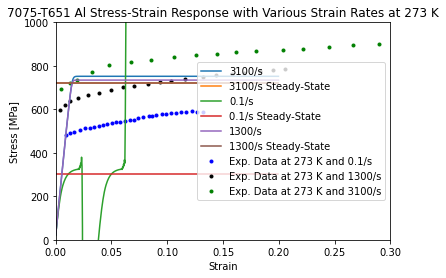

In [ ]:
# plt.close()
eps_297 =[3100,0.1,1300]
T = 297
N = 500
max_elong = 0.2
mu = 26.9e3
results_export = pd.DataFrame(columns = list(map(lambda x: str(x), eps_297)))
results_export["Step"] = range(0, N)
for i in range(0, len(eps_297)):
    time_step = max_elong/eps_297[i]/N   # Time step [seconds]https://info.gordon.tufts.edu/en/innovation-management?utm_campaign=MSIM%20Enrollment%20AY20-21&utm_source=email&utm_content=SOE
    V = C[1] * jnp.exp(-C[2] / T)                               # [MPa]
    f = C[5] * jnp.exp(-C[6] / T)                               # [1/s]
    R_d = C[13] * jnp.exp(-C[14] / T)                           # [1/MPa]
    H = C[15] * jnp.exp(C[16] / T)                              # [MPa]   Note: This eq. is different than the one from Dr. Cho, but it is what is used in this paper. This change approved by Dr. Cho                  
    R_s = C[17] * jnp.exp(-C[18] / T)                           # [1/s*MPa]
    res = stress_strain_relationship(T, N, max_elong, eps_297[i], mu, C)
    # print(eps_297[i])
    steady_state = jnp.sqrt((H*eps_297[i])/(R_d*eps_297[i]+R_s))
    print("H: "+str(H*eps_297[i]))
    print("R_d: "+str(R_d*eps_297[i]+R_s))
    print("Eps: "+str(eps_297[i]))
    print(steady_state)
    plt.plot(eps_297[i]*time_step*np.arange(0, N), res["Sigma"],label = str(eps_297[i])+"/s")
    plt.plot(eps_297[i]*time_step*np.arange(0, N), np.ones(N)*steady_state, label = str(eps_297[i])+ "/s Steady-State")
    results_export[str(eps_297[i])] = res["Sigma"]

plt.title('7075-T651 Al Stress-Strain Response with Various Strain Rates at 273 K')
plt.xlabel('Strain')
plt.ylabel('Stress [MPa]')
# Overlaying experimental data from Salehghaffari paper   (JMD 11.19.20)
K297_eps01 = [0.009031131, 0.012752634,	0.016762956,	0.021631353,	0.025927447,	0.030797749,	0.034235386,	0.038818012,	0.04225603,	0.046265209,	0.050562064,	0.053713168,	0.058010785,	0.062307259,	0.066317581,	0.070328665,	0.07405093,	0.0786347,	0.083218469,	0.086369573,	0.090093361,	0.095250197,	0.098688215,	0.103271604,	0.107855373,	0.112152228,	0.116449846,	0.121893596,	0.12647889,	0.131636488]
K297_sig01 = [481.352955,	493.3086681,	497.2846976,	506.5770234,	513.2116774,	515.8550607,	518.5032068,	525.1369082,	526.4552659,	534.4206609,	538.3957378,	541.0448365,	542.3603365,	547.6652019,	551.6412314,	552.957684,	562.25382,	564.8981559,	567.5424918,	570.1915905,	574.1685726,	576.8110033,	578.129361,	582.1034854,	584.7478212,	588.7228982,	590.0383981,	591.3500878,	588.6752696,	588.6581234]
K297_eps1300 = [0.00360683,	0.008278087,	0.012658723,	0.020256443,	0.029316152,	0.038377282,	0.049191732,	0.060005471,	0.070530011,	0.082515117,	0.093915784,	0.103563485,	0.116134098,	0.132213127,	0.143613438,	0.15823119,	0.168756439,	0.183373836,	0.194775213,	0.205300463]
K297_sig1300 = [598.1773998,	620.0486027,	636.4520049,	650.6682868,	664.8845687,	674.72661,	687.8493317,	703.1591738,	708.6269745,	718.4690158,	727.217497,	731.5917375,	739.2466586,	747.9951397,	757.837181,	764.3985419,	767.6792224,	775.3341434,	781.8955043,	785.1761847]
K297_eps3100 = [0.004959082,	0.012687478,	0.018986636,	0.032443791,	0.048193974,	0.067101356,	0.085436816,	0.105776483,	0.126117675,	0.144740429,	0.161929756,	0.179120606,	0.203474787,	0.221524475,	0.24473138,	0.266506,	0.289999819,	0.306904898]
K297_sig3100 = [692.8026626,	720.7025017,	736.6390072,	771.1687374,	803.03127,	816.2662854, 825.5138404,	840.0738814,	849.3147684,	855.9017938,	865.1531591,	869.0853703,	872.9937673,	879.5826979,	887.4842707,	894.0608178,	900.6316495,	901.9052364]
plt.scatter(K297_eps01,K297_sig01, marker= '.', color='b',label = 'Exp. Data at 273 K and 0.1/s')     # Formatting data points as blue circles
plt.scatter(K297_eps1300,K297_sig1300, marker= '.', color='k',label = 'Exp. Data at 273 K and 1300/s') # Formatting data points as black circles
plt.scatter(K297_eps3100,K297_sig3100, marker='.', color='g',label = 'Exp. Data at 273 K and 3100/s')  # Green circles for T = 297 K, eps_dot = 3100
plt.legend(loc = 'center right')
plt.xlim(0,0.3)
plt.ylim(0,1000)
plt.savefig("temp_273.png")
results_export.to_csv(str(T)+"_stress_strain.csv")

In [1]:
eps_473 =[3100]
T = 473
N = 500
max_elong = 0.2
mu = 26.9e3
results_export = pd.DataFrame(columns = list(map(lambda x: str(x), eps_473)))
results_export["Step"] = range(0, N)
for i in range(0, len(eps_473)):
    time_step = max_elong/eps_473[i]/N                          # Time step [seconds]
    V = C[1] * jnp.exp(-C[2] / T)                               # [MPa]
    f = C[5] * jnp.exp(-C[6] / T)                               # [1/s]
    R_d = C[13] * jnp.exp(-C[14] / T)                           # [1/MPa]
    H = C[15] * jnp.exp(C[16] / T)                              # [MPa]   Note: This eq. is different than the one from Dr. Cho, but it is what is used in this paper. This change approved by Dr. Cho                  
    R_s = C[17] * jnp.exp(-C[18] / T)                           # [1/s*MPa]
    res = stress_strain_relationship(T, N, max_elong, eps_473[i], mu, C)
    # print(eps_297[i])
    steady_state = jnp.sqrt((H*eps_473[i])/(R_d*eps_473[i]+R_s))
    print('Steady State ', steady_state)
    # print("H: "+str(H*eps_673[i]))
    # print("R_d: "+str(R_d*eps_673[i]+R_s))
    print("Eps: "+str(eps_473[i]))
    # print(steady_state)
    plt.plot(eps_473[i]*time_step*np.arange(0, N), res["Sigma"],label = str(eps_473[i])+" 1/s")
    plt.plot(eps_473[i]*time_step*np.arange(0, N), np.ones(N)*steady_state, label = str(eps_473[i])+ " 1/s Steady-State")
    results_export[str(eps_473[i])] = res["Sigma"]

plt.title('7075-T651 Al Viscoplastic Response with Various Strain Rates at 473 K')
plt.xlabel('Strain')
plt.ylabel('Stress [MPa]')
K473_eps3100 = [0.003370922,	0.008919727,	0.016809135,	0.026455416,	0.03990251,	0.05832001,	0.074108418,	0.094865454,	0.12205666,	0.153339657,	0.188132847,	0.227312002,	0.253042641,	0.285497716,	0.29982449]
K473_sig1300 = [424.3013366,	445.0789793,	461.4823815,	470.2308627,	480.072904,	491.0085055,	494.2891859,	504.1312272,	509.5990279,	520.5346294,	527.0959903,	533.6573512,	534.7509113,	538.0315917,	540.218712]
plt.scatter(K473_eps3100,K473_sig1300, marker = '.', color = 'b', label = 'Exp. Data at 473 K and 3100/s')
plt.legend()
plt.grid()
plt.xlim(0,0.3)
plt.ylim(0,1000)
plt.savefig("temp_473.png")
results_export.to_csv(str(T)+"_stress_strain.csv")

NameError: ignored

Steady State  109.65578938966341
Eps: 10
Steady State  3.565492268816528
Eps: 0.01
Steady State  35.55421608678236
Eps: 1


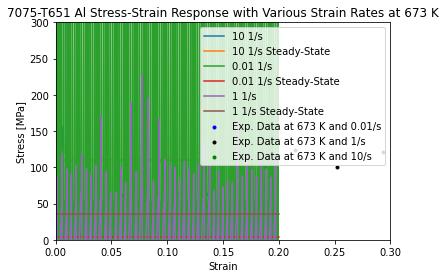

In [ ]:
np.sqrt(H*3100/(R_d*3100+R_s))# plt.close()
eps_673 = [10,0.01,1]
T = 673
N = 600
max_elong = 0.2
mu = 26.9e3
results_export = pd.DataFrame(columns = list(map(lambda x: str(x), eps_297)))
results_export["Step"] = range(0, N)
for i in range(0, len(eps_673)):
    time_step = max_elong/eps_673[i]/N   # Time step [seconds]
    V = C[1] * jnp.exp(-C[2] / T)                               # [MPa]
    f = C[5] * jnp.exp(-C[6] / T)                               # [1/s]
    R_d = C[13] * jnp.exp(-C[14] / T)                           # [1/MPa]
    H = C[15] * jnp.exp(C[16] / T)                              # [MPa]   Note: This eq. is different than the one from Dr. Cho, but it is what is used in this paper. This change approved by Dr. Cho                  
    R_s = C[17] * jnp.exp(-C[18] / T)                           # [1/s*MPa]
    res = stress_strain_relationship(T, N, max_elong, eps_673[i], mu, C)
    # print(eps_297[i])
    steady_state = ((H*eps_673[i])/(R_d*eps_673[i]+R_s))**0.5
    print('Steady State ', steady_state)
    # print("H: "+str(H*eps_673[i]))
    # print("R_d: "+str(R_d*eps_673[i]+R_s))
    print("Eps: "+str(eps_673[i]))
    # print(steady_state)
    plt.plot(eps_673[i]*time_step*np.arange(0, N), res["Sigma"],label = str(eps_673[i])+" 1/s")
    plt.plot(eps_673[i]*time_step*np.arange(0, N), np.ones(N)*steady_state, label = str(eps_673[i])+ " 1/s Steady-State")
    results_export[str(eps_673[i])] = res["Sigma"]

plt.title('7075-T651 Al Stress-Strain Response with Various Strain Rates at 673 K')
plt.xlabel('Strain')
plt.ylabel('Stress [MPa]')
K673_eps001 = [0.03006808,	0.043821675,	0.060727135,	0.077344919,	0.091099657,	0.109723936,	0.134938859,	0.157002299,	0.399696702]
K673_sig001 = [62.40003963,	62.35431624,	62.29811458,	66.23223099,	62.1971421,	63.46501351,	63.3811873,	61.97805087,	58.5116466]
K673_eps1 = [0.030967506,	0.045290728,	0.062246595,	0.09207009,	0.13095969,	0.187978655,	0.2517217,	0.331545906]
K673_sig1 = [82.01701094,	95.13973269,	104.981774,	108.2624544,	106.0753341,	101.7010936,	100.6075334,	101.7010936]
K673_eps10 = [0.129191811,	0.165294235,	0.214577568,	0.293374967,	0.389937426]
K673_sig10 = [120.5811442,	123.1206974,	124.2866437,	121.3651098,	118.3845165]
plt.scatter(K673_eps001,K673_sig001, marker = '.', color = 'b', label = 'Exp. Data at 673 K and 0.01/s')
plt.scatter(K673_eps1,K673_sig1, marker = '.', color = 'k', label = 'Exp. Data at 673 K and 1/s')
plt.scatter(K673_eps10,K673_sig10, marker = '.', color = 'g', label = 'Exp. Data at 673 K and 10/s')
plt.legend()
plt.xlim(0,0.3)
plt.ylim(0,300)
plt.savefig("temp_673.png")
results_export.to_csv(str(T)+"_stress_strain.csv")